[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/GradientDescent.ipynb)

# Gradient Descent
Given we can calculate the gradient of our cost function, we can minimize it by moving in the opposite direction of the gradient using some learning rate. You already saw a minimal implementation of this for the `fit` function in `LogisticRegression`. Here, we want to try different Gradient Descent methods, by implementing them independently of the underlying model. This way we can simply pass a `gradient()` function to the **optimizer** and ask it to find the optimal set of parameters for our model -- that is we don't need a specialized implementation say for `LinearRegression` and `LogisticRegression`. While there are different ways we could have a separate optimizer, here, we define an optimizer class -- such as `StochasticGradientDescent` -- and pass an instance of this class to the `fit` function for our model. The `fit` function could then `run` the optimizer to fit the data. Here, we only implement the vanilla `GradientDescent` class, since other methods will be part of your project.

In [51]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

In [52]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []
            
    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad = gradient_fn(x, y, w)
            w = w - self.learning_rate * grad
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return w

Note that in the implementation above we added an option to record the history of model parameter's during gradient descent for the purpose of visualization.
Let's reimplement the `LinearRegression` class to use an optimizer.

In [53]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass
            
    def fit(self, x, y, optimizer):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        def gradient(x, y, w):
            yh =  x @ w 
            N, D = x.shape
            grad = .5*np.dot(yh - y, x)/N
            return grad
        w0 = np.zeros(D)
        self.w = optimizer.run(gradient, x, y, w0)
        return self
    
    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh

Now let's fit this model to to the toy data we saw in the linear regression notebook.

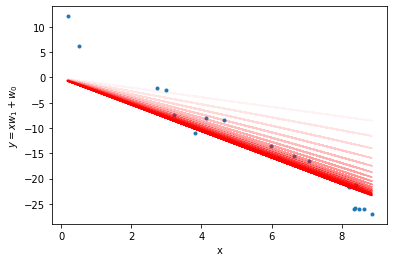

In [54]:
N = 20
x = np.random.rand(N) * 10
y = -4*x + 10 + 2*np.random.randn(N)
optimizer = GradientDescent(learning_rate=.01, max_iters=20, record_history=True)
model = LinearRegression()
model.fit(x,y, optimizer)
plt.plot(x, y, '.')
for t,w in enumerate(optimizer.w_history):
    plt.plot(x, x*w[0]+w[1], 'r-', alpha=t/len(optimizer.w_history), label=str(t))
plt.xlabel('x')
plt.ylabel(r'$y=xw_1 + w_0$')
#plt.xlim(-20,20)
#plt.ylim(-100,100)
plt.show()

## Change of learning rate
Next, let's visualize the effect of learning rate on the behaviour of gradient descent in linear regression.
Again, we use the plot-contour function to visualize the optimization landscape. 

In [55]:
import itertools
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

Let's track the steps of the 
gradient descent using different values for the learning rate.

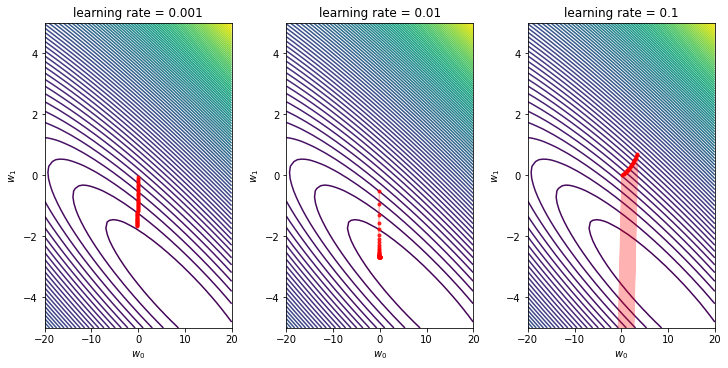

In [62]:
cost = lambda w: .5*np.mean((w[0] + w[1]*x - y)**2)
learning_rates = [.001, .01, .1]
fig, axes = plt.subplots(ncols=len(learning_rates), nrows=1, constrained_layout=True, figsize=(10, 5))
for i, lr in enumerate(learning_rates):
    optimizer = GradientDescent(learning_rate=lr, max_iters=50, record_history=True)
    model = LinearRegression(optimizer)
    model.fit(x,y, optimizer)
    plot_contour(cost, [-20,20], [-5,5], 50, axes[i])
    w_hist = np.vstack(optimizer.w_history)# T x 2
    axes[i].plot(w_hist[:,1], w_hist[:,0], '.r', alpha=.8)
    axes[i].plot(w_hist[:,1], w_hist[:,0], '-r', alpha=.3)
    axes[i].set_xlabel(r'$w_0$')
    axes[i].set_ylabel(r'$w_1$')
    axes[i].set_title(f'learning rate = {lr}')
    axes[i].set_xlim([-20,20])
    axes[i].set_ylim([-5,5])
plt.show()